In [54]:
import os, random, glob
import numpy as np
import pandas as pd
import ujson as json
from PIL import Image
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
from matplotlib import ticker
import seaborn as sns
%matplotlib inline 

from keras.models import Sequential, Model, load_model
from keras.layers import GlobalAveragePooling2D, Flatten, Dropout, Dense
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras import backend as K
K.set_image_dim_ordering('tf')

from skimage.data import imread
from skimage.io import imshow,imsave
from skimage import img_as_float
import pandas as pd
import numpy as np
import cv2
from skimage.util import crop
from skimage.transform import rotate
from skimage.transform import resize
import matplotlib.pyplot as plt
%matplotlib inline
import math

In [57]:
TRAIN_DIR = '../data/train/'
TEST_DIR = '../data/test_stg1/'
TRAIN_CROP_DIR = '../data/train_crop/'
FISH_CLASSES = ['NoF', 'ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']
crop_classes=FISH_CLASSES[:]
crop_classes.remove('NoF')
print(crop_classes)
MODEL = 'Resnet50'
ROWS = 180
COLS = 320
BatchSize = 64
LearningRate = 1e-4
le = LabelEncoder()
le.fit(crop_classes)
le.transform(crop_classes)

['ALB', 'BET', 'DOL', 'LAG', 'OTHER', 'SHARK', 'YFT']


array([0, 1, 2, 3, 4, 5, 6])

In [37]:
#crop and cache to TRAIN_CROP_DIR
if not os.path.exists(TRAIN_CROP_DIR):
    os.mkdir(TRAIN_CROP_DIR)

for c in crop_classes:
    TRAIN_CROP_DIR_c = TRAIN_CROP_DIR + '{}/'.format(c)
    if not os.path.exists(TRAIN_CROP_DIR_c):
        os.mkdir(TRAIN_CROP_DIR_c)
    files = glob.glob(TRAIN_CROP_DIR_c+'*')
    for f in files:
        os.remove(f)
            
for c in crop_classes:
    j = json.load(open('../data/BBannotations/{}.json'.format(c), 'r'))
    for l in j: 
        filename = l["filename"]
        head, tail = os.path.split(filename)
        basename, file_extension = os.path.splitext(tail) 
        image = Image.open(TRAIN_DIR+c+'/'+tail)
        for i in range(len(l["annotations"])):
            a = l["annotations"][i]
            file_crop = TRAIN_CROP_DIR + '{}/'.format(a["class"])+c+'_'+basename+'_{}_'.format(i)+a["class"]+'.jpg'
            xmin = (a["x"])
            ymin = (a["y"])
            width = (a["width"])
            height = (a["height"])
            xmax = xmin + width
            ymax = ymin + height
            #save cropped img
            cropped = image.crop((max(xmin,0), max(ymin,0), xmax, ymax))
            #cropped = image[max(ymin,0):ymax, max(xmin,0):xmax]
            width_cropped, height_cropped = cropped.size
            if height_cropped > width_cropped: cropped = cropped.transpose(method=2)
            cropped.save(file_crop)
            if a["class"] != c: print(file_crop)

../data/train_crop/LAG/ALB_img_01800_6_LAG.jpg
../data/train_crop/LAG/ALB_img_03397_1_LAG.jpg
../data/train_crop/LAG/ALB_img_03451_1_LAG.jpg
../data/train_crop/LAG/ALB_img_03748_4_LAG.jpg
../data/train_crop/ALB/DOL_img_07212_1_ALB.jpg
../data/train_crop/ALB/DOL_img_07212_2_ALB.jpg
../data/train_crop/LAG/SHARK_img_06082_0_LAG.jpg
../data/train_crop/ALB/SHARK_img_06082_1_ALB.jpg
../data/train_crop/ALB/SHARK_img_06082_2_ALB.jpg


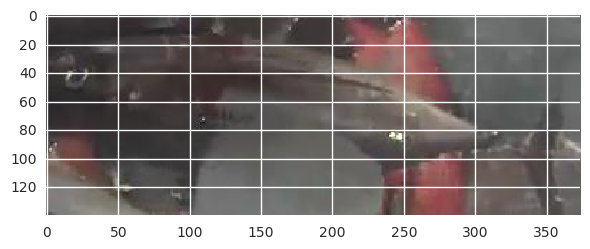

In [52]:
im = Image.open('../data/train_crop/ALB/SHARK_img_06082_2_ALB.jpg')
imshow(np.asarray(im))

In [39]:
im_sizes = []
for c in crop_classes:
    TRAIN_CROP_DIR_c = TRAIN_CROP_DIR + '{}/'.format(c)
    files = glob.glob(TRAIN_CROP_DIR_c+'*')
    for file in files:
        im = Image.open(file)
        #size = (width, height)
        size = im.size
        im_sizes.append(size)
im_sizes = np.asarray(im_sizes)

In [40]:
len(im_sizes)

4371

In [51]:
np.mean(im_sizes[:,1]/im_sizes[:,0])

0.56581649477718743

(array([  26.,  124.,  626.,  875.,  792.,  584.,  431.,  324.,  315.,  274.]),
 array([ 0.1187384 ,  0.20686456,  0.29499072,  0.38311688,  0.47124304,
         0.5593692 ,  0.64749536,  0.73562152,  0.82374768,  0.91187384,  1.        ]),
 <a list of 10 Patch objects>)

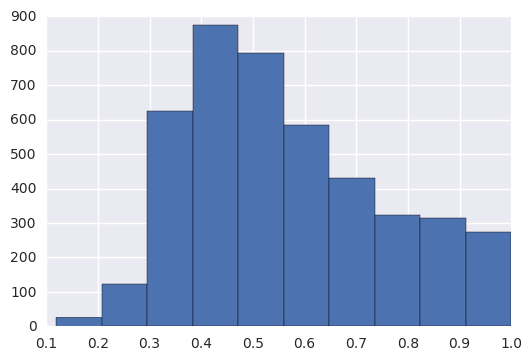

In [47]:
plt.hist(im_sizes[:,1]/im_sizes[:,0], bins=10)

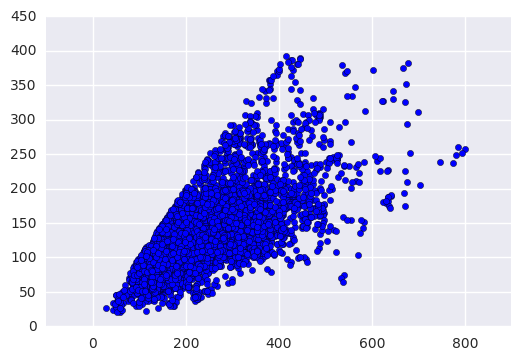

In [49]:
plt.scatter(im_sizes[:,0],im_sizes[:,1])  

In [59]:
#Loading data
import pickle

def get_images(fish):
    """Load files from train folder"""
    fish_dir = TRAIN_CROP_DIR+'{}'.format(fish)
    images = [fish+'/'+im for im in os.listdir(fish_dir)]
    return images

def read_image(src):
    """Read and resize individual images"""
    im = Image.open(src)
    im = im.resize((COLS, ROWS), Image.BILINEAR)
    im = np.asarray(im)
    return im

if os.path.exists('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist data_train_BBCrop_{}_{}.pickle. Loading data from file.'.format(ROWS, COLS))
    with open('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        data_train = pickle.load(f)
    X_train = data_train['X_train']
    y_train = data_train['y_train']
else:
    print ('Loading data from original images. Generating data_train_BBCrop_{}_{}.pickle.'.format(ROWS, COLS))
    
    files = []
    y_train = []

    for fish in crop_classes:
        fish_files = get_images(fish)
        files.extend(fish_files)

        y_fish = np.tile(fish, len(fish_files))
        y_train.extend(y_fish)
        #print("{0} photos of {1}".format(len(fish_files), fish))

    y_train = np.array(y_train)
    X_train = np.ndarray((len(files), ROWS, COLS, 3), dtype=np.uint8)

    for i, im in enumerate(files): 
        X_train[i] = read_image(TRAIN_CROP_DIR+im)
        if i%1000 == 0: print('Processed {} of {}'.format(i, len(files)))

    #X_train = X_train / 255.
    #print(X_train.shape)

    # One Hot Encoding Labels
    y_train = le.transform(y_train)
    y_train = np_utils.to_categorical(y_train)
    
    #save data to file
    data_train = {'X_train': X_train,'y_train': y_train }

    with open('../data/data_train_BBCrop_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(data_train, f)

X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=None, stratify=y_train)

Exist data_train_BBCrop_180_320.pickle. Loading data from file.


In [61]:
#data preprocessing

train_datagen = ImageDataGenerator(
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rescale=1./255,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=[0.9,1.1],
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True,
    vertical_flip=True)

#train_datagen.fit(X_train)
train_generator = train_datagen.flow(X_train, y_train, batch_size=BatchSize, shuffle=True, seed=None)

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_generator = valid_datagen.flow(X_valid, y_valid, batch_size=BatchSize, shuffle=True, seed=None)

In [62]:
#callbacks

early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=1, mode='auto')        

model_checkpoint = ModelCheckpoint(filepath='./checkpoints/weights.{epoch:03d}-{val_loss:.4f}.hdf5', monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto')
        
learningrate_schedule = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=5, verbose=1, mode='auto', epsilon=0.001, cooldown=0, min_lr=0)

tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=True)


In [67]:
#Resnet50
#stg1 training

from keras.applications.resnet50 import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False)
x = base_model.output

#x = MaxPooling2D()(x)
#x = BatchNormalization()(x)
#x = Flatten()(x)
#x = Dense(512, activation='relu', init='glorot_normal')(x)
#x = BatchNormalization()(x)
#x = Dropout(0.2)(x)

x = GlobalAveragePooling2D()(x)
#x = Flatten()(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
#x = Dropout(0.5)(x)
#x = Dense(256, init='glorot_normal', activation='relu')(x)
#x = LeakyReLU(alpha=0.33)(x)
#x = Dropout(0.5)(x)
predictions = Dense(len(crop_classes), init='glorot_normal', activation='softmax')(x)

# this is the model we will train
model = Model(input=base_model.input, output=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional VGG16 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
optimizer = Adam(lr=LearningRate)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# train the model on the new data for a few epochs
model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

Epoch 1/300


KeyboardInterrupt: 

In [ ]:
#stg2 training

from keras.applications.vgg16 import VGG16

optimizer = Adam(lr=LearningRate)

base_model = VGG16(weights='imagenet', include_top=False)
# at this point, the top layers are well trained and we can start fine-tuning
# convolutional layers from inception V3. We will freeze the bottom N layers
# and train the remaining top layers.

# let's visualize layer names and layer indices to see how many layers
# we should freeze:
for i, layer in enumerate(base_model.layers):
   print(i, layer.name)

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 172 layers and unfreeze the rest:
for layer in model.layers[:14]:
   layer.trainable = False
for layer in model.layers[14:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
hist = model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

In [ ]:
#resume training

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
print('Loading model from checkpoints file ' + files[index])
model = load_model(files[index])

hist = model.fit_generator(train_generator, samples_per_epoch=len(X_train), nb_epoch=300, verbose=1, 
                    callbacks=[early_stopping, model_checkpoint, learningrate_schedule, tensorboard], 
                    validation_data=valid_generator, nb_val_samples=len(X_valid), nb_worker=3, pickle_safe=True)

In [ ]:
#test submission

import datetime

if os.path.exists('../data/data_test_{}_{}.pickle'.format(ROWS, COLS)):
    print ('Exist data_test_{}_{}.pickle. Loading test data from file.'.format(ROWS, COLS))
    with open('../data/data_test_{}_{}.pickle'.format(ROWS, COLS), 'rb') as f:
        data_test = pickle.load(f)
    X_test = data_test['X_test']
    test_files = data_test['test_files']
else:
    print ('Loading test data from original images. Generating data_test_{}_{}.pickle.'.format(ROWS, COLS))

    test_files = [im for im in os.listdir(TEST_DIR)]
    X_test = np.ndarray((len(test_files), ROWS, COLS, 3), dtype=np.uint8)

    for i, im in enumerate(test_files): 
        X_test[i] = read_image(TEST_DIR+im)
        if i%300 == 0: print('Processed {} of {}'.format(i, len(test_files)))
            
    data_test = {'X_test': X_test,'test_files': test_files }
    
    with open('../data/data_test_{}_{}.pickle'.format(ROWS, COLS), 'wb') as f:
        pickle.dump(data_test, f)
            
X_test = X_test / 255.

files = glob.glob('./checkpoints/*')
val_losses = [float(f.split('-')[-1][:-5]) for f in files]
index = val_losses.index(min(val_losses))
model = load_model(files[index])

test_preds = model.predict(X_test, batch_size=BatchSize, verbose=1)
#test_preds= test_preds / np.sum(test_preds,axis=1,keepdims=True)

submission = pd.DataFrame(test_preds, columns=FISH_CLASSES)
#submission.loc[:, 'image'] = pd.Series(test_files, index=submission.index)
submission.insert(0, 'image', test_files)

now = datetime.datetime.now()
info = modelStr + '{:.4f}'.format(min(val_losses))
sub_file = 'submission_' + info + '_' + str(now.strftime("%Y-%m-%d-%H-%M")) + '.csv'
submission.to_csv(sub_file, index=False)

In [ ]:
# summarize history for accuracy
plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(hist.history['acc']); plt.plot(hist.history['val_acc']);
plt.title('model accuracy'); plt.ylabel('accuracy');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');

# summarize history for loss
plt.subplot(1, 2, 2)
plt.plot(hist.history['loss']); plt.plot(hist.history['val_loss']);
plt.title('model loss'); plt.ylabel('loss');
plt.xlabel('epoch'); plt.legend(['train', 'valid'], loc='upper left');
plt.show()